In [2]:
pip install kaggle

In [3]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"srimidhunask","key":"af20c6a0d62e22841404cc695472ff31"}'}

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!ls -l ~/.kaggle/


total 4
-rw------- 1 root root 68 Sep 19 07:57 kaggle.json


In [6]:
!kaggle datasets download -d puneet6060/intel-image-classification


Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 89% 308M/346M [00:00<00:00, 451MB/s]
100% 346M/346M [00:00<00:00, 494MB/s]


In [7]:
!unzip intel-image-classification.zip -d intel-image-classification


Streaming output truncated to the last 5000 lines.
  inflating: intel-image-classification/seg_train/seg_train/mountain/7506.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7537.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7539.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7551.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7560.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7565.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7578.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7581.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7586.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7647.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7652.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/

In [8]:
!ls intel-image-classification


seg_pred  seg_test  seg_train


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import (Dense , Conv2D , MaxPooling2D , Flatten ,Dropout , BatchNormalization , MaxPool2D , GlobalAveragePooling2D)
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from sklearn.metrics import confusion_matrix

In [10]:
train_path = "/content/intel-image-classification/seg_train/seg_train"
test_path = "/content/intel-image-classification/seg_test/seg_test"
pred_path = "/content/intel-image-classification/seg_pred/seg_pred"

In [11]:
image_size = (228 , 228)
batch_size = 32

In [12]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_path,
    seed  = 42,
    image_size = image_size,
    batch_size = batch_size
)

Found 14034 files belonging to 6 classes.


In [13]:
test_data = tf.keras.utils.image_dataset_from_directory(
    test_path,
    seed = 42,
    image_size = image_size ,
    batch_size = batch_size
)

Found 3000 files belonging to 6 classes.


In [14]:
classes_names = train_data.class_names
print(classes_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [15]:
def get_image_path(path):
    image_path = []
    for dirname , _ , filenames in os.walk(path):
        for filename in filenames :
            fullpath = os.path.join(dirname , filename)
            image_path.append(fullpath)
    return image_path

images_paths = get_image_path(pred_path)
len(images_paths)

7301

In [16]:
images_paths = get_image_path(train_path)
len(images_paths)

14034

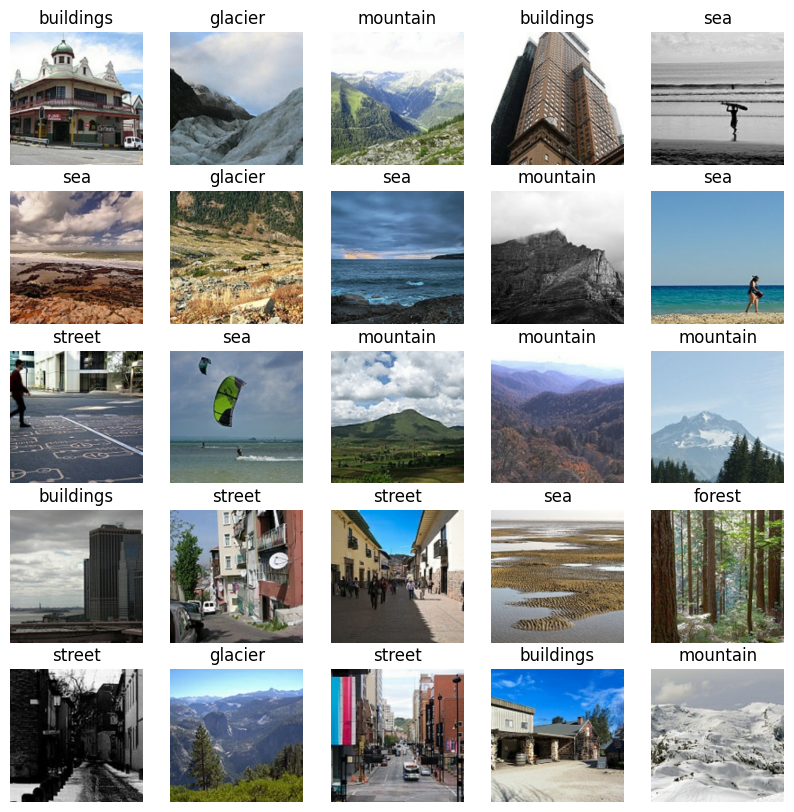

In [17]:
plt.figure(figsize = (10,10))
for images , labels in train_data.take(2):
    for i in range(25):
        ax = plt.subplot(5 ,5 , i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(classes_names[labels[i]])
        plt.axis('off')

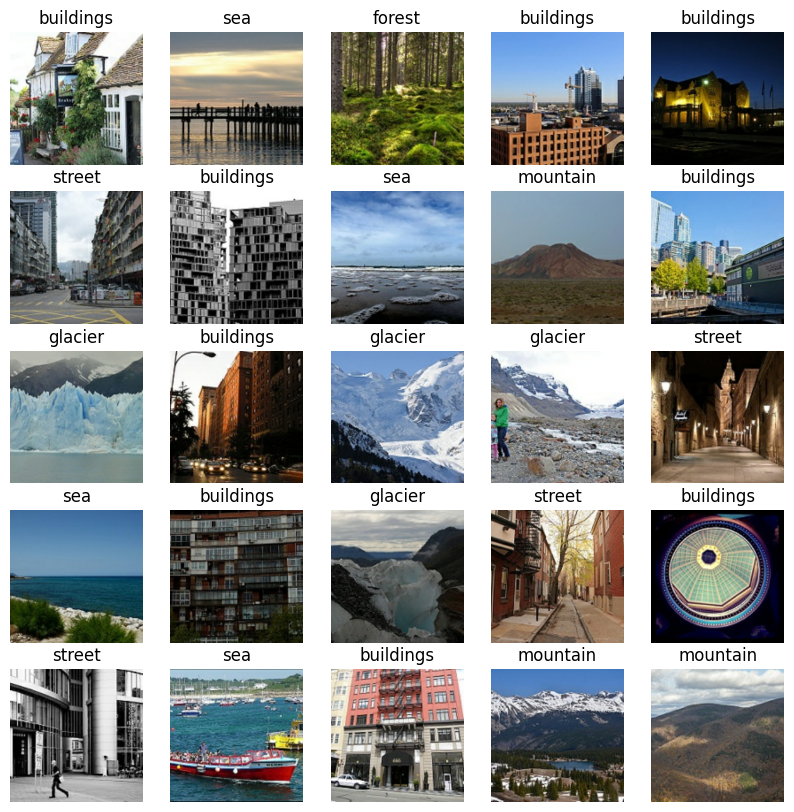

In [18]:
plt.figure(figsize = (10,10))
for images , labels in test_data.take(1):
    for i in range(25):
        ax = plt.subplot(5 , 5 , i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(classes_names[labels[i]])
        plt.axis('off')

In [19]:
class_counts = {}
for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path , class_name)
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))
        class_counts[class_name] = num_images
for class_name , count in class_counts.items():
    print(f"{class_name}: {count} images")

forest: 2271 images
sea: 2274 images
mountain: 2512 images
street: 2382 images
buildings: 2191 images
glacier: 2404 images


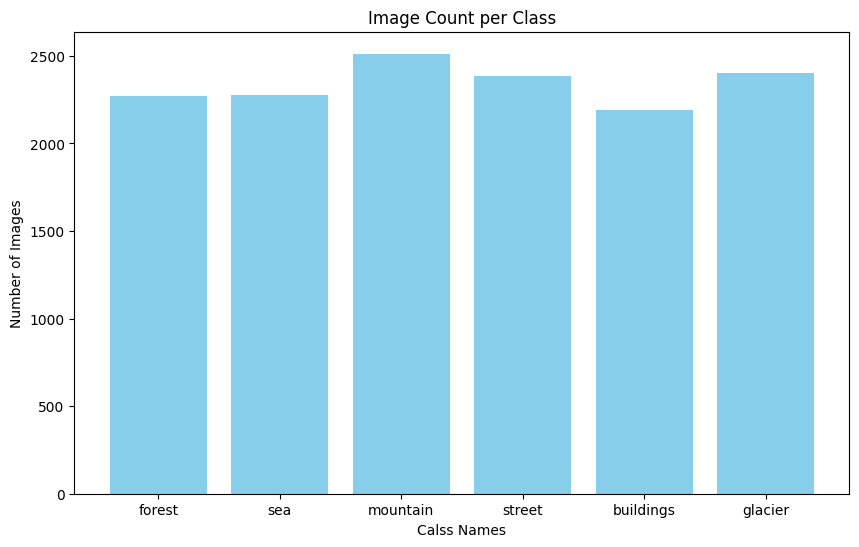

In [20]:
plt.figure(figsize = (10 , 6))
plt.bar(class_counts.keys() , class_counts.values() , color = 'skyblue')
plt.title("Image Count per Class")
plt.xlabel("Calss Names")
plt.ylabel("Number of Images")
plt.show()

In [21]:
class_counts = {}
for class_name in os.listdir(test_path):
    class_dir = os.path.join(test_path , class_name)
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))
        class_counts[class_name] = num_images
for class_name , count in class_counts.items():
    print(f"{class_name}: {count} images")

forest: 474 images
sea: 510 images
mountain: 525 images
street: 501 images
buildings: 437 images
glacier: 553 images


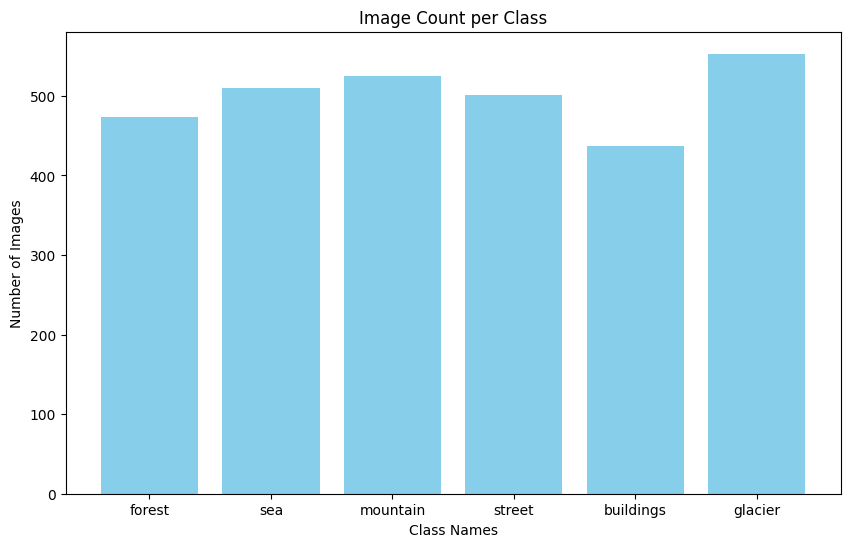

In [22]:
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Image Count per Class')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.show()

In [23]:
Norm_layer = tf.keras.layers.Rescaling(1/255)
train_data = train_data.map(lambda x , y : (Norm_layer(x) , y))
test_data = test_data.map(lambda x , y : (Norm_layer(x) , y))

In [24]:
model = Sequential()
model.add(Input(shape = (228 , 228 , 3)))
model.add(Conv2D(32 , kernel_size = (5,5) , activation = 'relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(32 , kernel_size = (5,5) , activation = 'relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64 , kernel_size = (3,3) , activation = 'relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128 , kernel_size = (3,3) , activation = 'relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(256 , kernel_size = (3,3) , activation = 'relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(512 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(len(classes_names) , activation = 'softmax'))

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 108, 108, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,759,334 (14.34 MB)

 Trainable params: 3,759,334 (14.34 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
from tensorflow.keras.optimizers import Adamax
op = Adamax(learning_rate=0.0005)
model.compile(optimizer = op,
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [27]:
early_stopping = EarlyStopping(monitor = 'val_accuracy' , patience = 5 , restore_best_weights = True)

In [28]:
history = model.fit(train_data , validation_data = test_data , epochs = 50,
                   callbacks = [early_stopping])

Epoch 1/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 43s 73ms/step - accuracy: 0.4467 - loss: 1.3405 - val_accuracy: 0.6433 - val_loss: 0.8908
Epoch 2/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 26s 59ms/step - accuracy: 0.6441 - loss: 0.9253 - val_accuracy: 0.7323 - val_loss: 0.7261
Epoch 3/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.7144 - loss: 0.7803 - val_accuracy: 0.7363 - val_loss: 0.6956
Epoch 4/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.7527 - loss: 0.6808 - val_accuracy: 0.7740 - val_loss: 0.6088
Epoch 5/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.7882 - loss: 0.6039 - val_accuracy: 0.7937 - val_loss: 0.5794
Epoch 6/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.7965 - loss: 0.5489 - val_accuracy: 0.8230 - val_loss: 0.4990
Epoch 7/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.8168 - loss: 0.5147 - val_accuracy: 0.8370 - val_loss: 0.4780
Epoch 8/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 26s 59ms/step - accuracy: 0.8358 - loss: 0.4653 - 

In [29]:
loss , accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {accuracy * 100 : .2f}%")

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8706 - loss: 0.3997
Test Accuracy:  85.97%


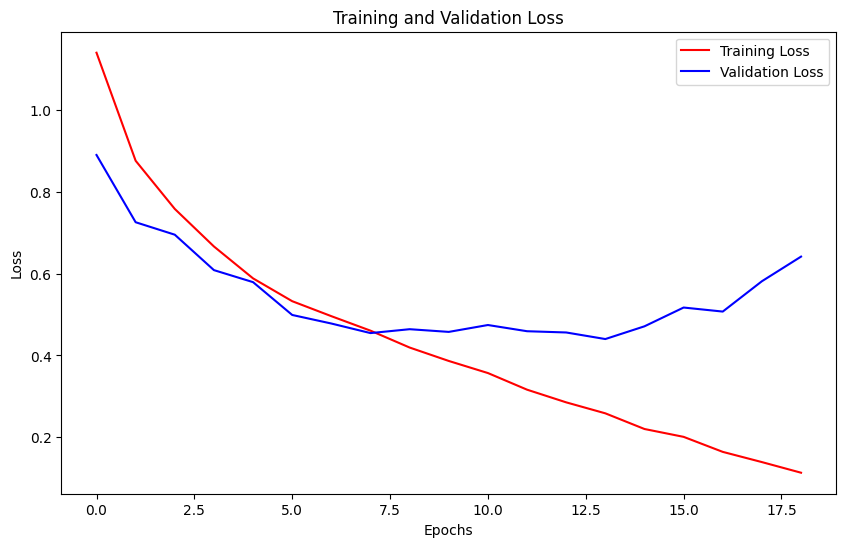

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, c="red", label="Training Loss")
plt.plot(epochs, val_loss, c="blue", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

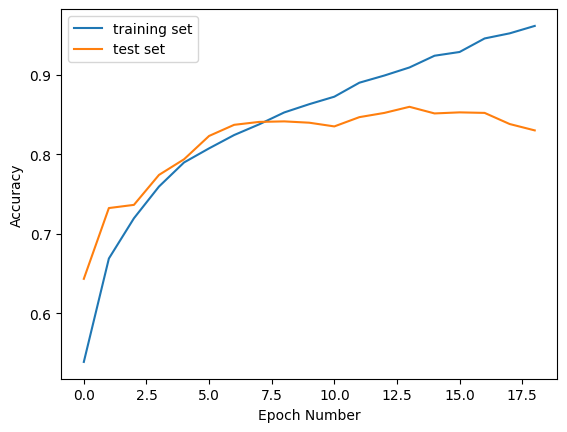

In [31]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()
plt.show()

In [32]:
def prediction(file_name , model):
    img = image.load_img(file_name , target_size = (228,228))
    img_array = image.img_to_array(img)
    img_pro = np.expand_dims(img_array , axis = 0)
    img_pro/=255
    img_pred = model.predict(img_pro)
    index = np.argmax(img_pred)

    plt.title("Prediction - {}".format(str(classes_names[index]).title()), size=18, color='red')
    plt.imshow(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step


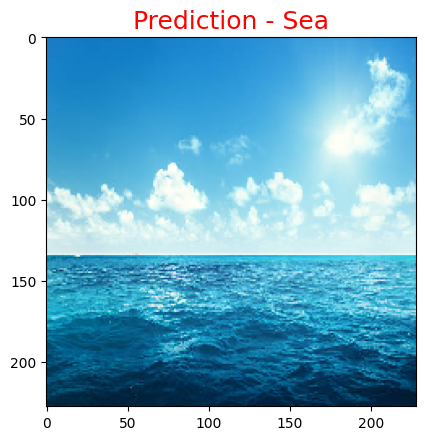

In [33]:
prediction("/content/istockphoto-467367026-612x612.jpg" , model)